# 해외 축구 선수 이적료 예측 미션

* 패키지 임포트

In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import GridSearchCV , KFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import catboost as cb
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
from scipy.stats import skew
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from matplotlib import font_manager,rc # 한글 글꼴 사용
rc('font', family='AppleGothic') 

pd.set_option('display.max_row',100)
pd.set_option('display.max_column',100)

---

* 데이터 불러오기

In [2]:
train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')
submission = pd.read_csv('submission.csv')

* 전체 데이터 비율

In [3]:
print('train data ratio :',len(train)/(len(train)+len(test)))
print('test data ratio :',len(test)/(len(train)+len(test)))

train data ratio : 0.7
test data ratio : 0.3


* 데이터 확인

In [4]:
train.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [5]:
test.head()

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


* 데이터 분포 확인

In [6]:
train.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,7966.775750,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,16948.000000,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [7]:
test.describe()

,id,age,reputation,stat_overall,stat_potential,stat_skill_moves
count,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000
mean,7846.258098,25.297806,1.143939,67.336991,72.107628,2.414838
std,4870.339361,4.628236,0.448465,6.908814,6.133428,0.781153
min,1.000000,16.000000,1.000000,47.000000,52.000000,1.000000
25%,3466.250000,22.000000,1.000000,63.000000,68.000000,2.000000
50%,7643.500000,25.000000,1.000000,67.000000,72.000000,2.000000
75%,11967.000000,29.000000,1.000000,72.000000,76.000000,3.000000
max,16943.000000,42.000000,5.000000,94.000000,95.000000,5.000000


자료들의 최소,최대값이 크게 벗어나는건 없는것 같습니다.  

* 데이터 정보 확인

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3828 non-null   int64  
 1   name              3828 non-null   object 
 2   age               3828 non-null   int64  
 3   continent         3828 non-null   object 
 4   contract_until    3828 non-null   object 
 5   position          3828 non-null   object 
 6   prefer_foot       3828 non-null   object 
 7   reputation        3828 non-null   float64
 8   stat_overall      3828 non-null   int64  
 9   stat_potential    3828 non-null   int64  
 10  stat_skill_moves  3828 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 329.1+ KB


* 결측치 확인

In [10]:
train.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
value               0
dtype: int64

In [11]:
test.isnull().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64

  
  결측지도 없는것으로 보입니다.

* 중복값 확인

In [12]:
train[train.duplicated()]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value


In [13]:
test[test.duplicated()]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves


중복값도 확인되지 않습니다.

* 필요없는 변수 제거
* id, name은 분석에 사용되지 않기때문에 제거합니다.

In [14]:
train_copy = train.copy()
test_copy = test.copy()

train_copy.drop(['id','name'],axis=1,inplace=True)
test_copy.drop(['id','name'],axis=1,inplace=True)

## 데이터 구조 확인

* 학습데이터 변수 확인

In [15]:
train_copy['age'].unique()

array([31, 27, 32, 25, 26, 29, 33, 30, 40, 24, 28, 34, 23, 22, 35, 36, 21,
       18, 19, 37, 20, 39, 17, 38, 16])

In [16]:
train_copy['continent'].unique()

array(['south america', 'europe', 'africa', 'asia', 'oceania'],
      dtype=object)

In [17]:
train_copy['contract_until'].unique()
# 변수 확인 필요

array(['2021', '2020', '2019', '2023', '2022', '2024', 'Jun 30, 2019',
       '2026', 'Dec 31, 2018', '2018', '2025', 'Jun 30, 2020',
       'May 31, 2020', 'May 31, 2019', 'Jan 31, 2019', 'Jan 1, 2019',
       'Jan 12, 2019'], dtype=object)

데이터 구조를 통일시켜야 할 것 같습니다.

In [18]:
train_copy['position'].unique()

array(['ST', 'GK', 'DF', 'MF'], dtype=object)

In [19]:
train_copy['prefer_foot'].unique()

array(['left', 'right'], dtype=object)

In [20]:
train_copy['reputation'].unique()

array([5., 4., 3., 1., 2.])

In [21]:
train_copy['stat_overall'].unique()

array([94, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76,
       75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59,
       58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47])

In [22]:
train_copy['stat_potential'].unique()

array([94, 93, 91, 90, 92, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78,
       77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61,
       60, 59, 58, 57, 56, 55, 54, 53, 52, 50, 48])

In [23]:
train_copy['stat_skill_moves'].unique()

array([4., 1., 3., 2., 5.])

* 테스트 데이터 변수 확인

In [24]:
test_copy['age'].unique()

array([33, 26, 27, 32, 29, 28, 24, 30, 19, 25, 31, 22, 23, 37, 35, 34, 36,
       21, 20, 40, 38, 18, 39, 17, 42, 16])

In [25]:
test_copy['continent'].unique()

array(['europe', 'south america', 'africa', 'asia', 'oceania'],
      dtype=object)

In [26]:
test_copy['contract_until'].unique()
# 변수 확인 필요

array(['2022', '2023', '2020', '2021', 'Jun 30, 2019', '2019', '2025',
       '2024', '2018', 'May 31, 2020', 'Jun 30, 2020', 'May 31, 2019',
       'Dec 31, 2019', 'Dec 31, 2018', 'Jun 1, 2019', 'Jan 1, 2019',
       'Jan 31, 2019', '2026'], dtype=object)

데이터 구조를 통일시켜야 할 것 같습니다.

In [27]:
test_copy['position'].unique()

array(['ST', 'MF', 'DF', 'GK'], dtype=object)

In [28]:
test_copy['prefer_foot'].unique()

array(['right', 'left'], dtype=object)

In [29]:
test_copy['reputation'].unique()

array([5., 4., 3., 2., 1.])

In [30]:
test_copy['stat_overall'].unique()

array([94, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77,
       76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60,
       59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47])

In [31]:
test_copy['stat_potential'].unique()

array([94, 93, 92, 91, 90, 89, 95, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79,
       78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62,
       61, 60, 59, 58, 57, 56, 55, 54, 52])

In [32]:
test_copy['stat_skill_moves'].unique()

array([5., 4., 3., 2., 1.])

### contract_until 변수 확인

In [33]:
train_copy['contract_until'].value_counts()

2019            2366
2021            2308
2020            2041
2022             761
2023             506
Jun 30, 2019     501
2018             327
Dec 31, 2018      64
May 31, 2019      19
2024              12
Jan 31, 2019      10
Jun 30, 2020       9
2025               3
Jan 1, 2019        2
2026               1
May 31, 2020       1
Jan 12, 2019       1
Name: contract_until, dtype: int64

In [34]:
test_copy['contract_until'].value_counts()

2021            985
2019            943
2020            882
2022            338
2023            251
Jun 30, 2019    209
2018            155
Dec 31, 2018     34
May 31, 2019     14
2025              4
Jun 30, 2020      4
2024              2
Jan 31, 2019      2
Jan 1, 2019       1
May 31, 2020      1
Jun 1, 2019       1
Dec 31, 2019      1
2026              1
Name: contract_until, dtype: int64

* contract_until 변수를 년도 4자리로만 표기

In [35]:
contract_train = []
contract_test = []
for i in train_copy['contract_until']:
    contract_train.append(i[-4:])
for i in test_copy['contract_until']:
    contract_test.append(i[-4:])

train_copy['contract_until'] = contract_train
test_copy['contract_until'] = contract_test

# 데이터 형식을 수치형으로 변환
train_copy['contract_until'] = train_copy['contract_until'].astype('int64')
test_copy['contract_until'] = test_copy['contract_until'].astype('int64')

In [36]:
train_copy['contract_until'].value_counts()

2019    2899
2021    2308
2020    2051
2022     761
2023     506
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64

In [37]:
test_copy['contract_until'].value_counts()

2019    1171
2021     985
2020     887
2022     338
2023     251
2018     189
2025       4
2024       2
2026       1
Name: contract_until, dtype: int64

* 학습용 데이터 변수의 시각화

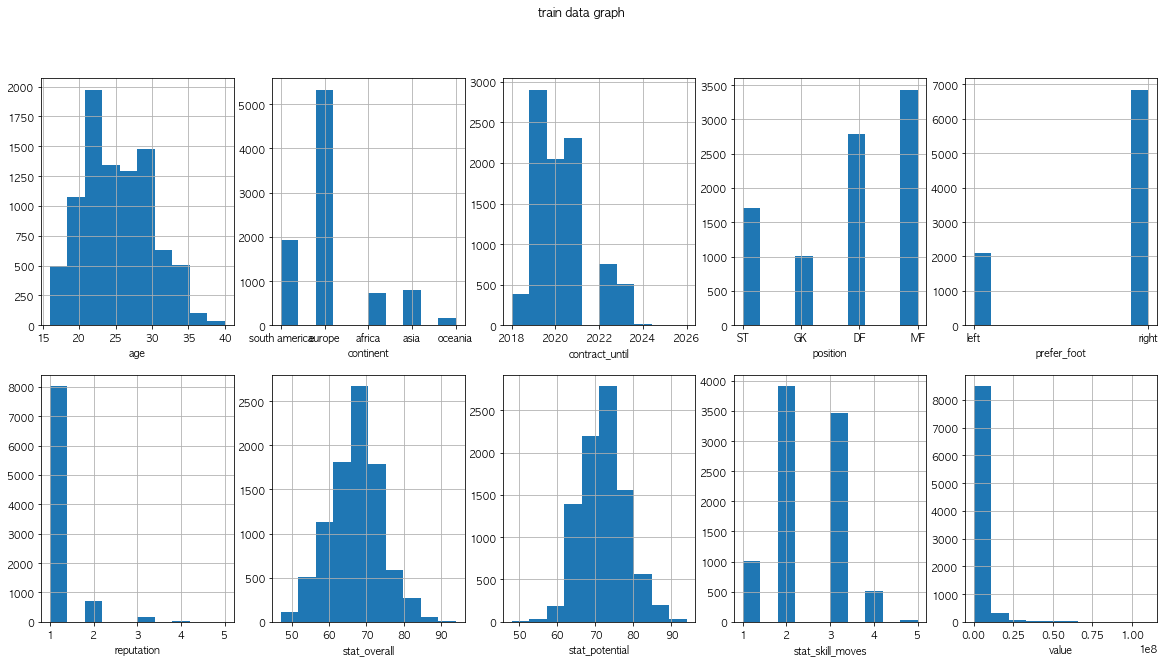

In [38]:
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()
col = train_copy.columns
for i in range(len(train_copy.columns)):
    train_copy[col[i]].hist(ax=ax[i])
    ax[i].set_xlabel(col[i])
plt.suptitle('train data graph')    
plt.show()

* 테스트 데이터 변수의 시각화

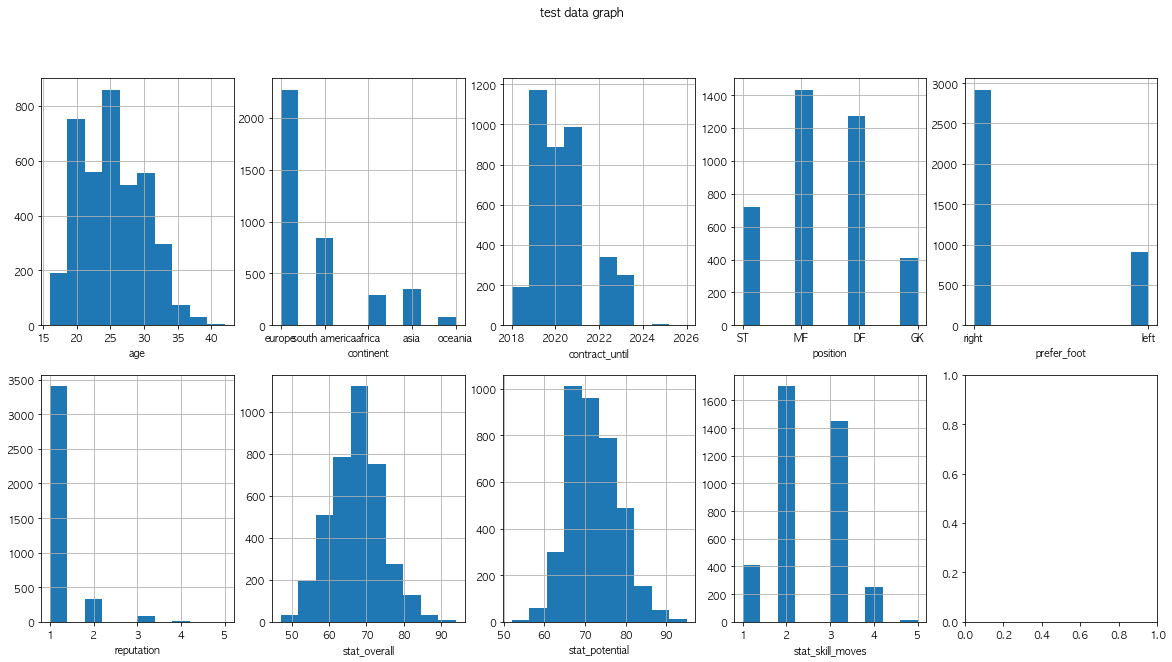

In [116]:
fig, ax = plt.subplots(2,5, figsize=(20,10))
ax = ax.flatten()
col = test_copy.columns
for i in range(len(test_copy.columns)):
    test_copy[col[i]].hist(ax=ax[i])
    ax[i].set_xlabel(col[i])
plt.suptitle('test data graph')    
plt.show()

* 나이의 분포는 10대후반 부터 20대후반까지 모여있습니다.
* 유럽 대륙의 선수가 가장 많습니다.
* 2021년까지 계약이 된 선수들이 많습니다.
* 포지션별로 선수의 수가 차이를 보입니다.
* 오른발 선수가 왼발 선수보다 많습니다.
* 명성도는 1에 많이 몰려있습니다.
* 선수 능력치는 정규분포를 띄는것 같아 보이지만 실제로 확인이 필요합니다.
* 스킬 능력치는 2,3에 많이 분포되어 있습니다.

* 학습용 데이터 value에 따른 그래프

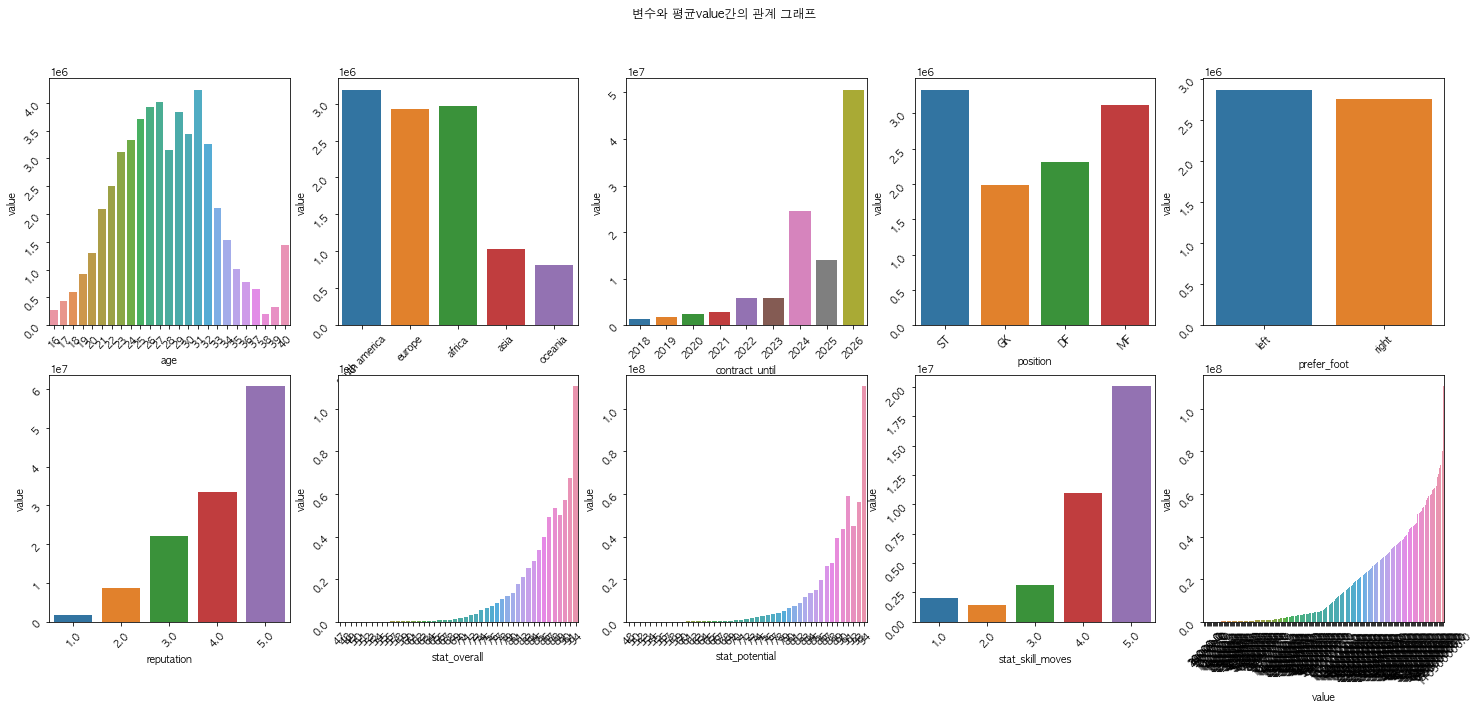

In [40]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
ax = ax.flatten()
col = train_copy.columns
for i in range(len(train_copy.columns)):
    sns.barplot(x=train_copy[col[i]],y=train_copy['value'],ci=0,ax=ax[i])
    ax[i].set_xlabel(col[i])
    ax[i].tick_params(labelrotation=45)
plt.suptitle('변수와 평균value간의 관계 그래프')    
plt.show()

* 28세와 40세에서 value값이 특이합니다. 확인을 해봐야 할 것 같습니다.
* 다른 대륙들보다 아시아, 오세아니아에서의 평균 value가 낮습니다.
* 2026년까지 계약한 선수의 평균이 눈에 띄게 높습니다.
* 포지션별로 value의 평균이 차이를 보입니다.
* 선호하는 발은 차이가 없어 보입니다.
* 명성도가 올라갈수록 value도 올라갑니다.
* 능력치가 올라갈수록 value도 올라갑니다.
* 스킬 능력치의 평균 value도 눈에 띄게 차이가 나기 때문에 확인이 필요합니다.

##### 40세에서 value가 높은 변수 확인

In [53]:
train[train['age']==40]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
23,41,G. Buffon,40,europe,2019,GK,right,4.0,88,88,1.0,4000000.0
1613,2735,S. Bertoli,40,south america,2019,GK,right,1.0,73,73,1.0,270000.0
5168,8995,B. Castillo,40,south america,2021,GK,right,1.0,66,66,1.0,40000.0


##### 28살에서 value의 평균이 왜 낮아졌을까

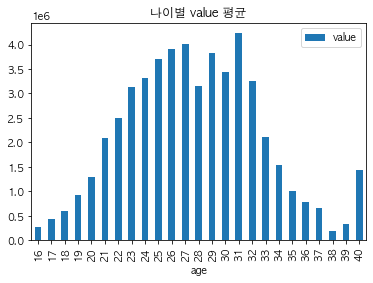

In [54]:
DataFrame(train.groupby('age')['value'].agg('mean')).sort_values(by='age').plot(kind='bar')
plt.title('나이별 value 평균')
plt.show()

* 나이별 value 최대값

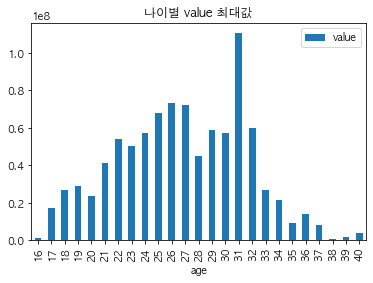

In [55]:
DataFrame(train.groupby('age')['value'].agg('max')).sort_values(by='age').plot(kind='bar')
plt.title('나이별 value 최대값')
plt.show()

28세에서 최대값이 많이 낮습니다.

In [56]:
DataFrame(train['age'].value_counts().sort_index()).T

,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
age,18,131,344,491,582,676,632,663,691,654,708,581,532,472,476,347,285,202,216,89,64,42,17,16,3


혹시나 싶어 나이별 인원 수를 확인해보니 28세에 인원수가 많이 떨어지는건 아닌 것 같습니다.

* 28세와 28세가 아닌 선수들의 데이터 분포 그래프

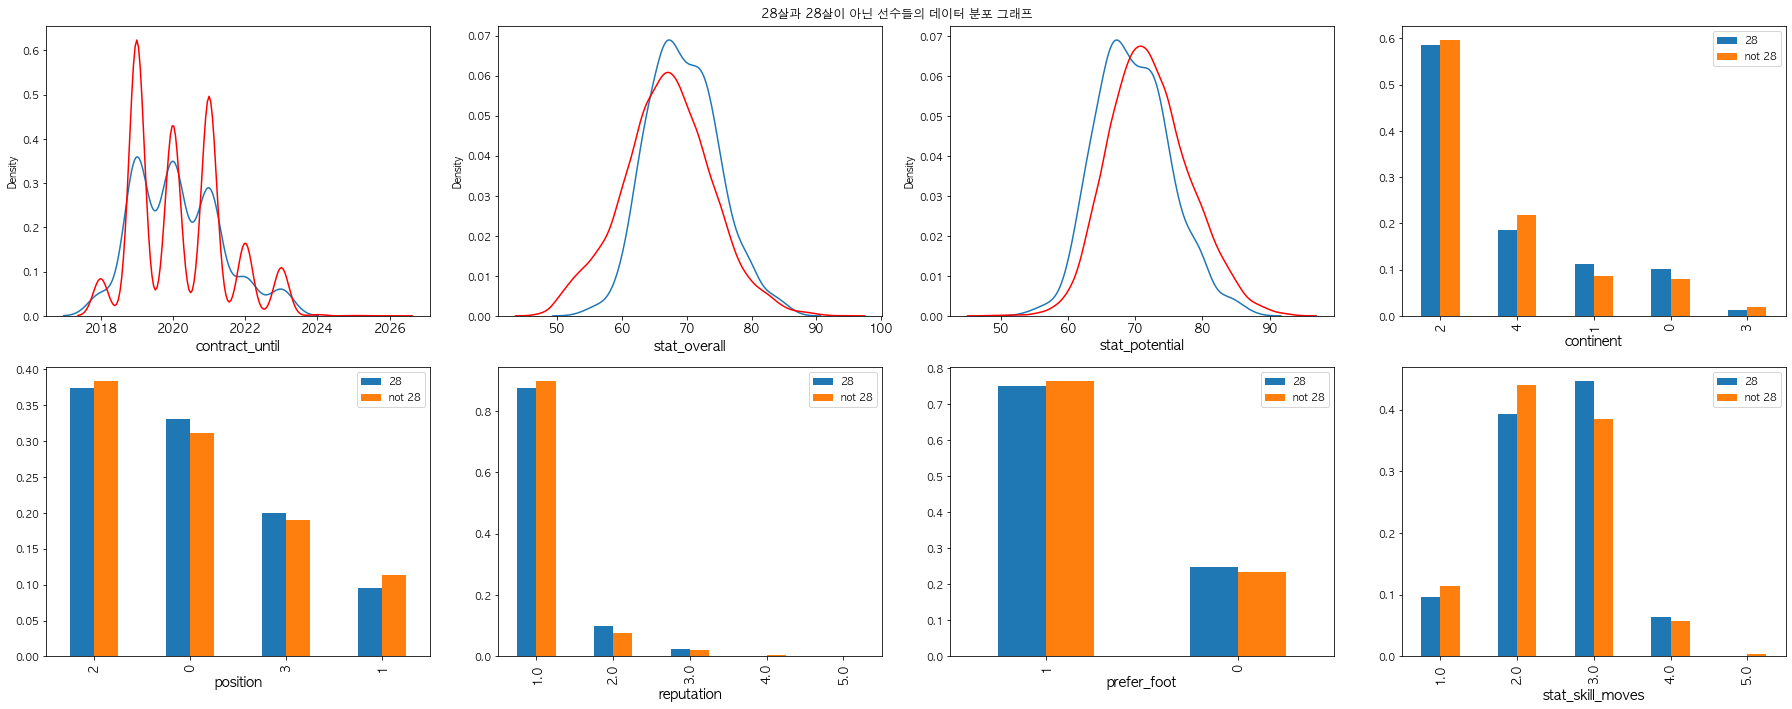

In [135]:
fig, ax = plt.subplots(2,4, figsize=(25,10))
ax = ax.flatten()
col = ['contract_until','stat_overall','stat_potential','continent','position','reputation','prefer_foot','stat_skill_moves']
for i in range(len(col)):
    if i < 3:
        sns.distplot(train_copy[train_copy['age']==28][col[i]],kde=True,hist=False,hist_kws=({'alpha':1}),label='28',ax=ax[i])
        sns.distplot(train_copy[train_copy['age']!=28][col[i]],kde=True,hist=False,kde_kws=({'color':'red'}),label='not 28',ax=ax[i])
        ax[i].set_xlabel(col[i],fontsize=14)
        ax[i].tick_params(axis = 'x', labelsize =12)

    else:
        
        train_28 = pd.DataFrame(train_copy[train_copy['age']==28][col[i]].value_counts() / len(train_copy[train_copy['age']==28]))
        train_28.rename(columns={col[i]:'28'},inplace=True)

        train_not28 = pd.DataFrame(train_copy[train_copy['age']!=28][col[i]].value_counts() / len(train_copy[train_copy['age']!=28]))
        train_not28.rename(columns={col[i]:'not 28'},inplace=True)

        pd.concat([train_28,train_not28],axis=1).plot(kind='bar',ax=ax[i])
        ax[i].set_xlabel(col[i],fontsize=14)
        ax[i].tick_params(axis = 'x', labelsize =12)
    
plt.suptitle('28살과 28살이 아닌 선수들의 데이터 분포 그래프')    
plt.legend()
plt.tight_layout()
plt.show()

* 28세인 선수와 28세가 아닌 선수의 데이터 분포는 차이가 없습니다.
* 28세 선수 중 많은 value를 받는 선수가 없어서 평균값이 낮게 나오는 것 같습니다.

In [41]:
# 대륙별 이적료 최소,최대,평균, 선수 인원 합
train.groupby('continent')['value'].agg(['min','max','mean','size'])

,min,max,mean,size
continent,,,,
africa,20000.0,69500000.0,2.972247e+06,721
asia,10000.0,14500000.0,1.035146e+06,787
europe,10000.0,73500000.0,2.928125e+06,5322
oceania,30000.0,10500000.0,8.225429e+05,175
south america,20000.0,110500000.0,3.183204e+06,1927


### 대륙별 value의 평균의 차이가 있을까?

* 대륙별 value의 정규성 검정

In [42]:
europe_normality = stats.shapiro(train.loc[train.continent == "europe", "value"])
south_america_normality = stats.shapiro(train.loc[train.continent == "south america", "value"])
africa_normality = stats.shapiro(train.loc[train.continent == "africa", "value"])
asia_normality = stats.shapiro(train.loc[train.continent == "asia", "value"])
oceania_normality = stats.shapiro(train.loc[train.continent == "oceania", "value"])
print("europe        : ",europe_normality)
print("south america : ",south_america_normality)
print("africa        : ",africa_normality)
print("asia          : ",asia_normality)
print("oceania       : ",oceania_normality)

europe        :  ShapiroResult(statistic=0.466699481010437, pvalue=0.0)
south america :  ShapiroResult(statistic=0.4463731646537781, pvalue=0.0)
africa        :  ShapiroResult(statistic=0.44311290979385376, pvalue=2.2476827367770066e-42)
asia          :  ShapiroResult(statistic=0.4933406710624695, pvalue=1.8567204652303826e-42)
oceania       :  ShapiroResult(statistic=0.5149554014205933, pvalue=8.66416155841569e-22)


/Users/keyonbit/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


* 대륙별 value의 ANOVA분석

In [43]:
# 대륙별 value, ANOVA
model = ols('value ~ C(continent)', train).fit()
print(anova_lm(model))

                  df        sum_sq       mean_sq          F        PR(>F)
C(continent)     4.0  3.523251e+15  8.808128e+14  26.107688  1.499155e-21
Residual      8927.0  3.011763e+17  3.373768e+13        NaN           NaN


In [44]:
europe_normality = stats.shapiro(train.loc[train.continent == "europe", "value"])
south_america_normality = stats.shapiro(train.loc[train.continent == "south america", "value"])
africa_normality = stats.shapiro(train.loc[train.continent == "africa", "value"])
asia_normality = stats.shapiro(train.loc[train.continent == "asia", "value"])
oceania_normality = stats.shapiro(train.loc[train.continent == "oceania", "value"])
print("europe        : ",europe_normality)
print("south america : ",south_america_normality)
print("africa        : ",africa_normality)
print("asia          : ",asia_normality)
print("oceania       : ",oceania_normality)

europe        :  ShapiroResult(statistic=0.466699481010437, pvalue=0.0)
south america :  ShapiroResult(statistic=0.4463731646537781, pvalue=0.0)
africa        :  ShapiroResult(statistic=0.44311290979385376, pvalue=2.2476827367770066e-42)
asia          :  ShapiroResult(statistic=0.4933406710624695, pvalue=1.8567204652303826e-42)
oceania       :  ShapiroResult(statistic=0.5149554014205933, pvalue=8.66416155841569e-22)


/Users/keyonbit/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### 포지션별 value의 평균 차이

* 포지션별 value의 정규성 검정

In [45]:
ST_normality = stats.shapiro(train.loc[train.position == "ST", "value"])
MF_normality = stats.shapiro(train.loc[train.position == "MF", "value"])
DF_normality = stats.shapiro(train.loc[train.position == "DF", "value"])
GK_normality = stats.shapiro(train.loc[train.position == "GK", "value"])
print("ST   : ",ST_normality)
print("MF   : ",MF_normality)
print("DF   : ",DF_normality)
print("GK   : ",GK_normality)

ST   :  ShapiroResult(statistic=0.42586350440979004, pvalue=0.0)
MF   :  ShapiroResult(statistic=0.4915241599082947, pvalue=0.0)
DF   :  ShapiroResult(statistic=0.47648388147354126, pvalue=0.0)
GK   :  ShapiroResult(statistic=0.33884352445602417, pvalue=0.0)


* 포지션별 vlaue의 ANOVA분석

In [46]:
# 포지션별 value, ANOVA
model = ols('value ~ C(position)', train).fit()
print(anova_lm(model))

                 df        sum_sq       mean_sq          F        PR(>F)
C(position)     3.0  2.174063e+15  7.246875e+14  21.386665  8.478638e-14
Residual     8928.0  3.025254e+17  3.388502e+13        NaN           NaN


### 선호하는 발에 따른 value의 평균 차이

* 선호하는 발에 따른 value의 정규성 검정

In [47]:
right_normality = stats.shapiro(train.loc[train.prefer_foot == "right", "value"])
left_normality = stats.shapiro(train.loc[train.prefer_foot == "left", "value"])
print("DF   : ",right_normality)
print("GK   : ",left_normality)

DF   :  ShapiroResult(statistic=0.4550599455833435, pvalue=0.0)
GK   :  ShapiroResult(statistic=0.4254606366157532, pvalue=0.0)


/Users/keyonbit/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


* 선호하는 발에 따른 value의 ANOVA 분석

In [48]:
# 선호하는 발에 따른 value, ANOVA
model = ols('value ~ C(prefer_foot)', train).fit()
print(anova_lm(model))
# 평균의 차이가 없다

                    df        sum_sq       mean_sq         F    PR(>F)
C(prefer_foot)     1.0  2.050612e+13  2.050612e+13  0.601025  0.438208
Residual        8930.0  3.046790e+17  3.411859e+13       NaN       NaN


### 포지션별 대륙

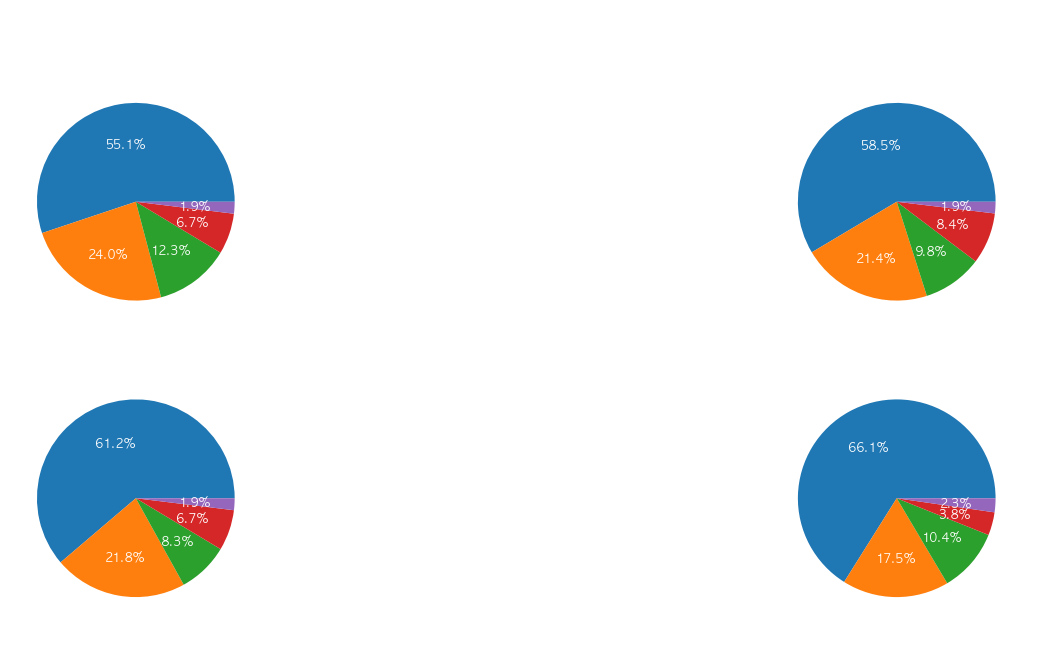

In [50]:
fig, ax = plt.subplots(2,2, figsize=(25,10))
ax = ax.flatten()
labels = ['europe','south america','africa', 'asia', 'oceania']    
ax[0].pie(train[train['position']=='ST']['continent'].value_counts() / len(train[train['position']=='ST']),
       labels=(train[train['position']=='ST']['continent'].value_counts() / len(train[train['position']=='ST'])).index,autopct='%.1f%%',textprops={'size':12,'color':'white'})
ax[0].set_xlabel('ST continent',fontsize=15,color='white')

ax[1].pie(train[train['position']=='MF']['continent'].value_counts() / len(train[train['position']=='MF']),
       labels=(train[train['position']=='MF']['continent'].value_counts() / len(train[train['position']=='MF'])).index,autopct='%.1f%%',textprops={'size':12,'color':'white'})
ax[1].set_xlabel('MF continent',fontsize=15,color='white')

ax[2].pie(train[train['position']=='DF']['continent'].value_counts() / len(train[train['position']=='DF']),
       labels=(train[train['position']=='DF']['continent'].value_counts() / len(train[train['position']=='DF'])).index,autopct='%.1f%%',textprops={'size':12,'color':'white'},normalize=False)
ax[2].set_xlabel('DF continent',fontsize=15,color='white')

ax[3].pie(train[train['position']=='GK']['continent'].value_counts() / len(train[train['position']=='GK']),
       labels=(train[train['position']=='GK']['continent'].value_counts() / len(train[train['position']=='GK'])).index,autopct='%.1f%%',textprops={'size':12,'color':'white'},normalize=False)
ax[3].set_xlabel('GK continent',fontsize=15,color='white')
plt.suptitle('포지션별 대륙 비율',fontsize=20,color='white') 
plt.show()

### 대륙별 포지션

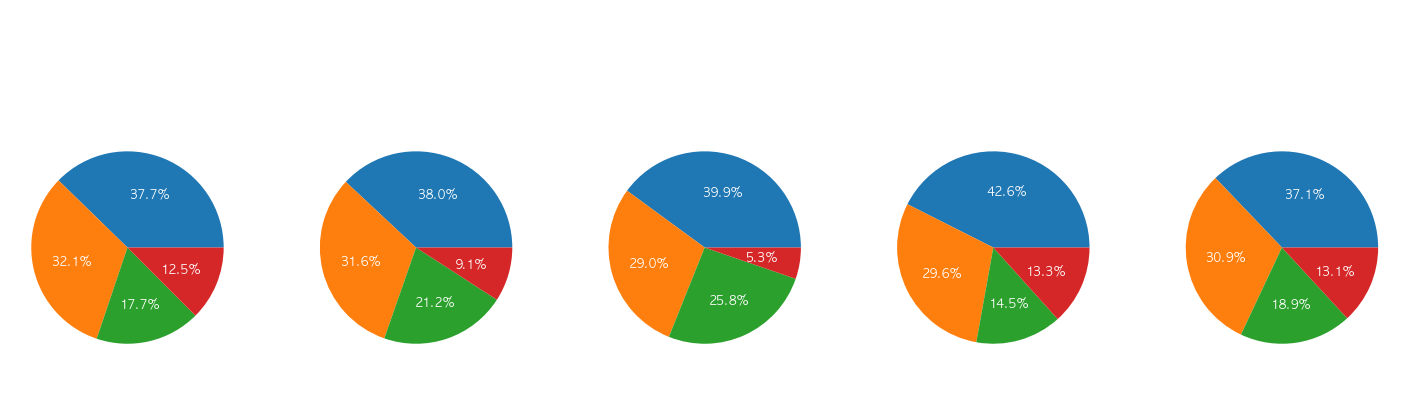

In [51]:
fig, ax = plt.subplots(1,5, figsize=(25,7))
ax = ax.flatten()
    
ax[0].pie(train[train['continent']=='europe']['position'].value_counts() / len(train[train['continent']=='europe']),
       labels=(train[train['continent']=='europe']['position'].value_counts() / len(train[train['continent']=='europe'])).index,autopct='%.1f%%',textprops={'size':12,'color':'white'},normalize=False)
ax[0].set_xlabel('europe',fontsize=15,color='white')

ax[1].pie(train[train['continent']=='south america']['position'].value_counts() / len(train[train['continent']=='south america']),
       labels=(train[train['continent']=='south america']['position'].value_counts() / len(train[train['continent']=='south america'])).index,autopct='%.1f%%',textprops={'size':12,'color':'white'})
ax[1].set_xlabel('south america',fontsize=15,color='white')

ax[2].pie(train[train['continent']=='africa']['position'].value_counts() / len(train[train['continent']=='africa']),
       labels=(train[train['continent']=='africa']['position'].value_counts() / len(train[train['continent']=='africa'])).index,autopct='%.1f%%',textprops={'size':12,'color':'white'})
ax[2].set_xlabel('africa',fontsize=15,color='white')

ax[3].pie(train[train['continent']=='asia']['position'].value_counts() / len(train[train['continent']=='asia']),
       labels=(train[train['continent']=='asia']['position'].value_counts() / len(train[train['continent']=='asia'])).index,autopct='%.1f%%',textprops={'size':12,'color':'white'})
ax[3].set_xlabel('asia',fontsize=15,color='white')

ax[4].pie(train[train['continent']=='oceania']['position'].value_counts() / len(train[train['continent']=='oceania']),
       labels=(train[train['continent']=='oceania']['position'].value_counts() / len(train[train['continent']=='oceania'])).index,autopct='%.1f%%',textprops={'size':12,'color':'white'})
ax[4].set_xlabel('oceania',fontsize=15,color='white')
plt.suptitle('대륙별 포지션 비율',fontsize=20,color='white') 
plt.show()

In [52]:
# 대륙별 최고 몸값

DataFrame(train.groupby('continent')['value'].agg('max')).sort_values(by='value',ascending=False)

,value
continent,
south america,110500000.0
europe,73500000.0
africa,69500000.0
asia,14500000.0
oceania,10500000.0


---

#### 변수와 reputation 간의 관계

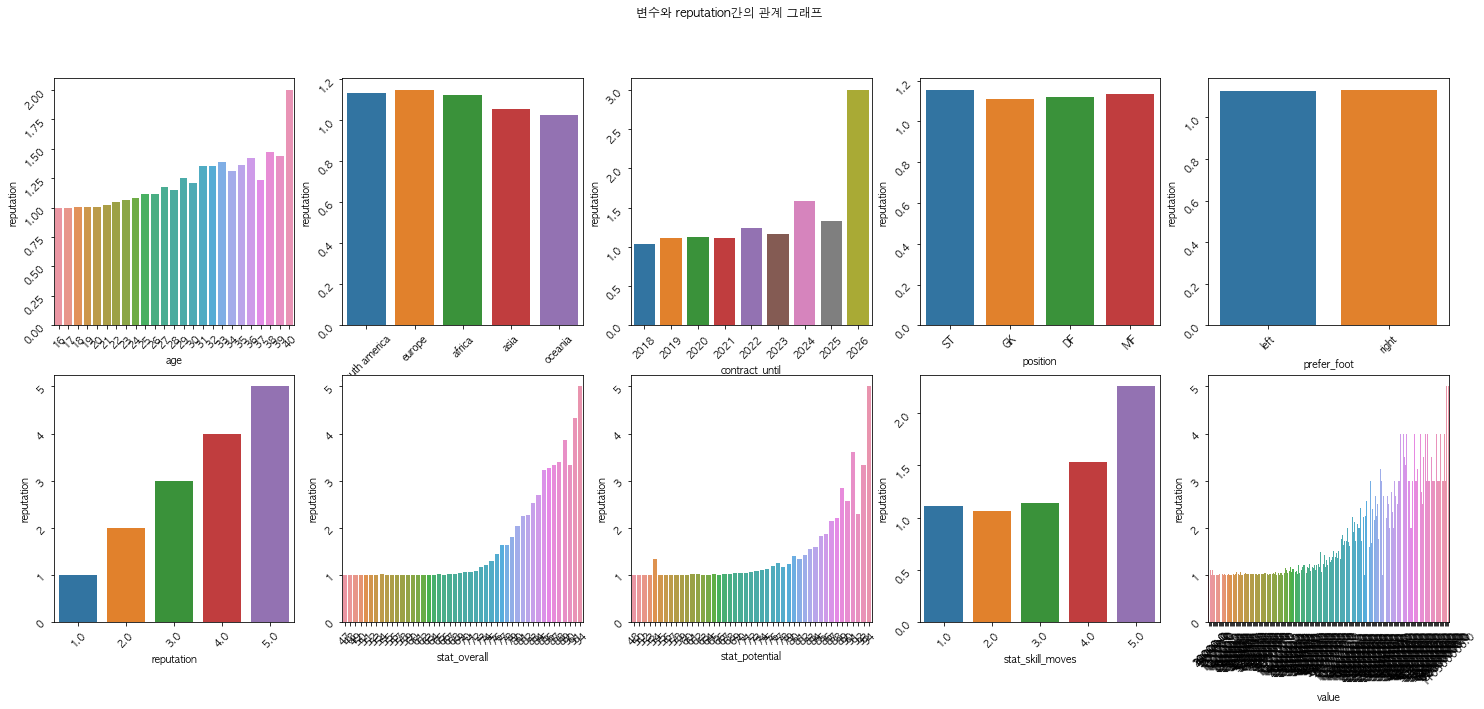

In [75]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
ax = ax.flatten()
col = train_copy.columns
for i in range(len(train_copy.columns)):
    sns.barplot(x=train_copy[col[i]],y=train_copy['reputation'],ci=0,ax=ax[i])
    ax[i].set_xlabel(col[i])
    ax[i].tick_params(labelrotation=45)
plt.suptitle('변수와 reputation간의 관계 그래프')    
plt.show()

In [86]:
rep1_normality = stats.shapiro(train.loc[train.stat_skill_moves == 1, "reputation"])
rep2_normality = stats.shapiro(train.loc[train.stat_skill_moves == 2, "reputation"])
rep3_normality = stats.shapiro(train.loc[train.stat_skill_moves == 3, "reputation"])
rep4_normality = stats.shapiro(train.loc[train.stat_skill_moves == 4, "reputation"])
rep5_normality = stats.shapiro(train.loc[train.stat_skill_moves == 5, "reputation"])
print("rep1   : ",rep1_normality)
print("rep2   : ",rep2_normality)
print("rep3   : ",rep3_normality)
print("rep4   : ",rep4_normality)
print("rep5   : ",rep5_normality)

rep1   :  ShapiroResult(statistic=0.2871057391166687, pvalue=0.0)
rep2   :  ShapiroResult(statistic=0.2255118489265442, pvalue=0.0)
rep3   :  ShapiroResult(statistic=0.37189245223999023, pvalue=0.0)
rep4   :  ShapiroResult(statistic=0.7063696384429932, pvalue=5.055149019812913e-29)
rep5   :  ShapiroResult(statistic=0.8698601722717285, pvalue=0.0013832947006449103)


In [87]:
# 선호하는 발에 따른 value, ANOVA
model = ols('reputation ~ C(stat_skill_moves)', train).fit()
print(anova_lm(model))

                         df       sum_sq    mean_sq           F         PR(>F)
C(stat_skill_moves)     4.0   142.462890  35.615723  217.538577  1.989762e-178
Residual             8927.0  1461.541028   0.163721         NaN            NaN


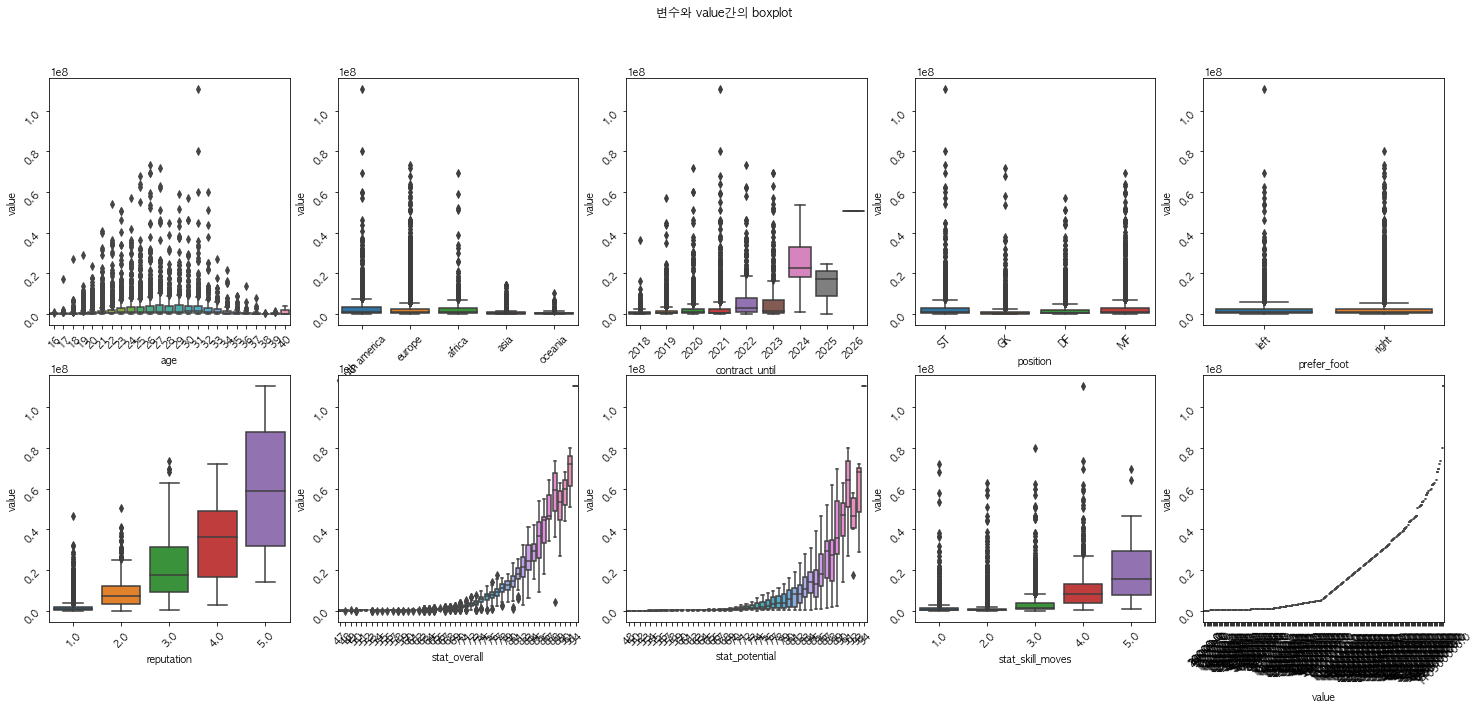

In [76]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
ax = ax.flatten()
col = train_copy.columns
for i in range(len(train_copy.columns)):
    sns.boxplot(x=train_copy[col[i]],y=train_copy['value'],ax=ax[i])
    ax[i].set_xlabel(col[i])
    ax[i].tick_params(labelrotation=45)
plt.suptitle('변수와 value간의 boxplot')    
plt.show()

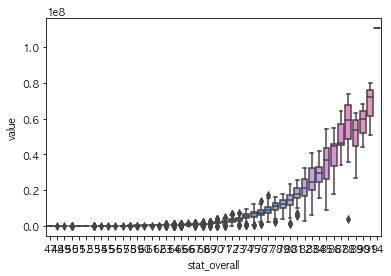

In [88]:
sns.boxplot(x=train_copy['stat_overall'],y=train_copy['value'])
plt.show()

In [89]:
train[(train['stat_overall']==91) & (train['stat_potential']==91)]

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0


* 이상치를 보유하고 있는 변수(메시) 제거 후 boxplot

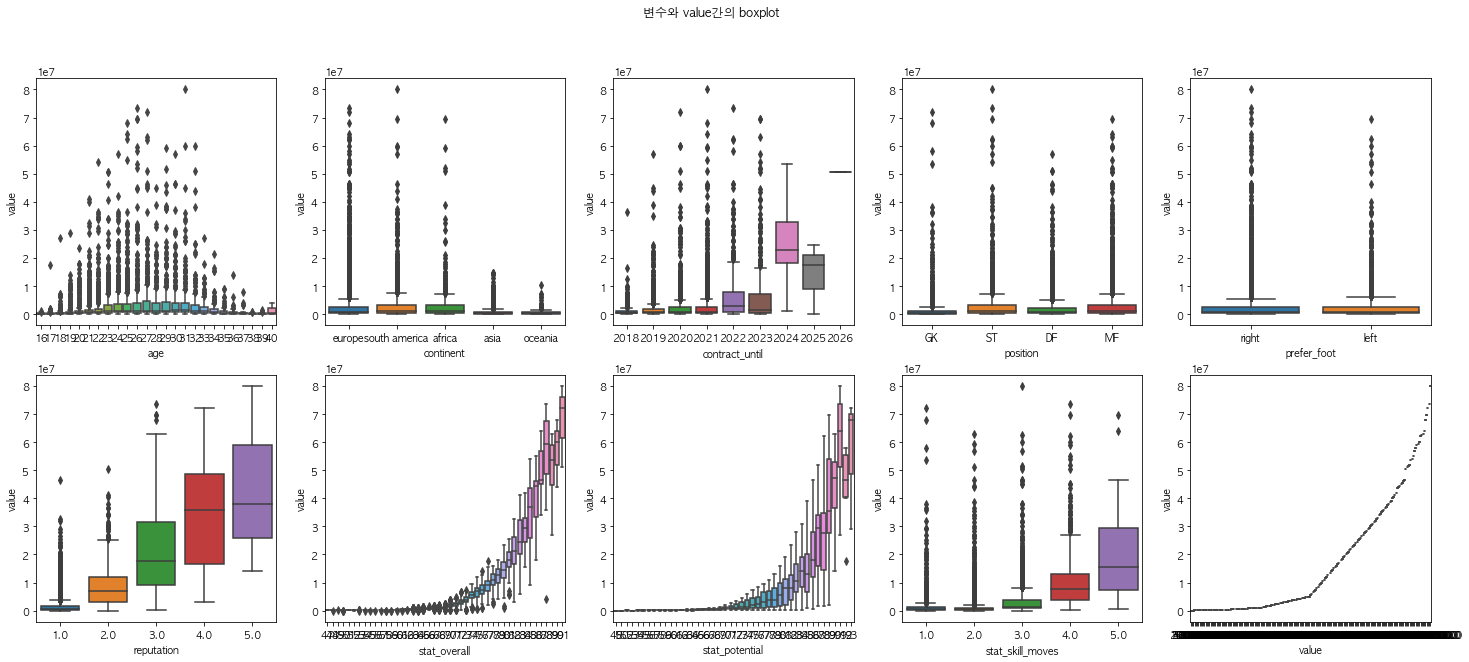

In [90]:
fig, ax = plt.subplots(2,5, figsize=(25,10))
ax = ax.flatten()
col = train_copy.columns
for i in range(len(train_copy.columns)):
    sns.boxplot(x=train_copy[col[i]].iloc[1:],y=train_copy['value'].iloc[1:],ax=ax[i])
    ax[i].set_xlabel(col[i])
plt.suptitle('변수와 value간의 boxplot')    
plt.show()

* 이상치(메시) 제거

In [ ]:
train_copy.iloc[1:]

* 학습용 데이터와 테스트 데이터의 변수 분포 확인

#### 수치형 자료의 분포

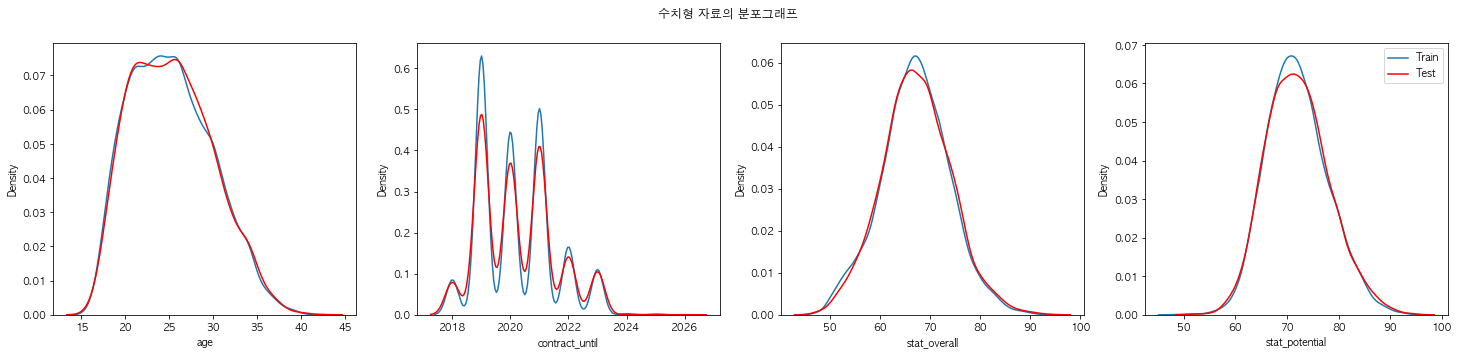

In [91]:
fig, ax = plt.subplots(1,4, figsize=(25,5))
ax = ax.flatten()
col = ['age','contract_until','stat_overall','stat_potential']
for i in range(len(col)):
    sns.distplot(train_copy[col[i]],kde=True,hist=False,hist_kws=({'alpha':1}),label='Train',ax=ax[i])
    sns.distplot(test_copy[col[i]],kde=True,hist=False,kde_kws=({'color':'red'}),label='Test',ax=ax[i])
    ax[i].set_xlabel(col[i])

plt.suptitle('수치형 자료의 분포그래프')    
plt.legend()
plt.show()

#### 범주형 자료의 비율

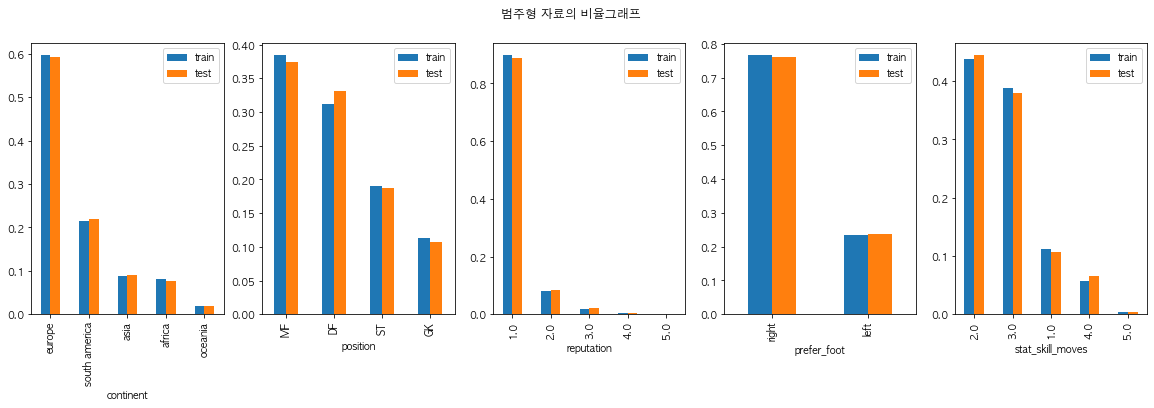

In [92]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
ax = ax.flatten()
col = ['continent','position','reputation','prefer_foot','stat_skill_moves']
for i in range(len(col)):

    train_continent = pd.DataFrame(train_copy[col[i]].value_counts() / len(train_copy))
    train_continent.rename(columns={col[i]:'train'},inplace=True)

    test_continent = pd.DataFrame(test_copy[col[i]].value_counts() / len(test_copy))
    test_continent.rename(columns={col[i]:'test'},inplace=True)

    pd.concat([train_continent,test_continent],axis=1).plot(kind='bar',ax=ax[i])
    ax[i].set_xlabel(col[i])  
plt.suptitle('범주형 자료의 비율그래프')
plt.show()

---

#### 상관계수

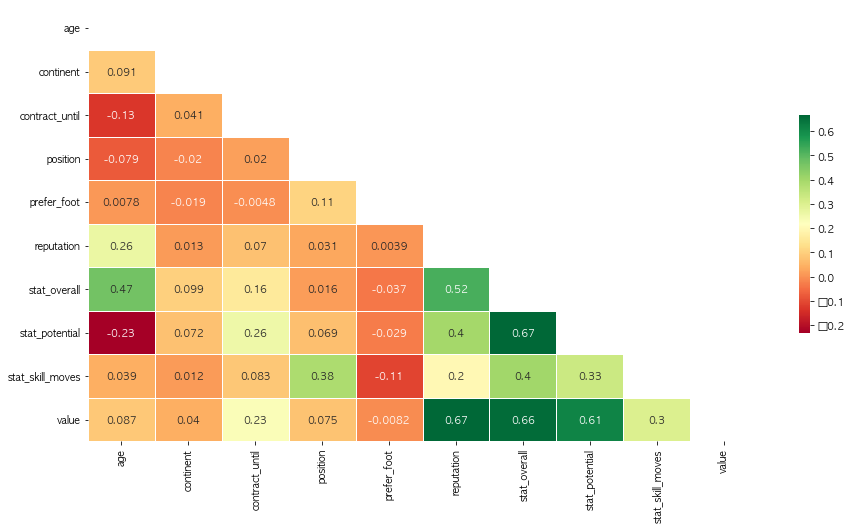

In [109]:
object_le = LabelEncoder()
train_copy[['continent','position','prefer_foot']] = train_copy[['continent','position','prefer_foot']].apply(object_le.fit_transform)

plt.figure(figsize=(15,8))
mask = np.zeros_like(train_copy.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_copy.corr(),cmap='RdYlGn',
            annot=True, # 실제값 표시
            mask=mask,  # 표시하지 않을 마스크 부분 지정
            linewidths=.5, # 경계면 실선 구분
            cbar_kws={'shrink':.5}) # 컬러바 절반으로 줄이기
            
plt.show()

* 나이에 따른 stat_overall 비교

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,8))
ax = ax.flatten()

sns.boxplot(train_copy['age'],train_copy['stat_overall'],ax=ax[0])
ax[0].set_title('age, stat_overall')
ax[0].tick_params(labelrotation=45)
plt.ylim(45,100)

sns.boxplot(train_copy['age'],train_copy['stat_potential'],ax=ax[1])
ax[1].set_title('age, stat_potential')
ax[1].tick_params(labelrotation=45)
plt.ylim(45,100)

sns.lineplot(train_copy['age'],train_copy['stat_overall'],ax=ax[2],label='overall',color='blue',ci=None,alpha=0.4)
sns.lineplot(train_copy['age'],train_copy['stat_potential'],ax=ax[2],label='potential',color='red',ci=None,alpha=0.5)
plt.ylim(45,100)
ax[2].set_title('stat_overall, stat_potential')
ax[2].tick_params(labelrotation=45)
plt.show()

In [ ]:
age_stat_ratio = round(train_copy[train_copy['stat_overall']==train_copy['stat_potential']]['age'].value_counts() / train_copy[train_copy['age']>=25]['age'].value_counts(),3) * 100

print('stat_overall과 stat_potential이 같은 비율')
DataFrame(age_stat_ratio).rename(columns={'age':'ratio'}).T

---
#### value와의 상관계수

In [ ]:
train_copy.drop('value',axis=1).corrwith(train['value']).sort_values()

In [ ]:
plt.figure(figsize=(30,8))
plt.barh(train_copy.drop('value',axis=1).corrwith(train['value']).sort_values().index,train_copy.drop('value',axis=1).corrwith(train['value']).sort_values())
plt.xlim(-1,1)
plt.show()

* reputatin, stat_overall, stat_potential의 상관 계수가 높다.